# 用训练得到的模型预测

同济子豪兄 2023-2-6

## 导入工具包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

import os
os.chdir('../../mmsegmentation')

## 载入模型

In [2]:
# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile('new_cfg.py')

In [3]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

06/15 16:13:21 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 42
    GPU 0: NVIDIA GeForce GTX 1080 Ti
    CUDA_HOME: /usr/local/cuda-11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50

/home/cine/Documents/GitHub/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/cine/Documents/GitHub/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/cine/Documents/GitHub/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/cine/Documents/GitHub/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the c

06/15 16:13:27 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/15 16:13:27 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/cine/Documents/GitHub/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [6]:
# 初始化模型
checkpoint_path = './work_dirs/tutorial/iter_2400_best_iou67acc81.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_2400_best_iou67acc81.pth


## 载入测试集图像，或新图像

In [7]:
img = mmcv.imread('Glomeruli-dataset/images/VUHSK_1702_39.png')

## 语义分割预测

In [8]:
result = inference_model(model, img)

In [9]:
result.keys()

['seg_logits', 'pred_sem_seg']

In [10]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [11]:
pred_mask.shape

(1024, 1024)

In [12]:
np.unique(pred_mask)

array([0, 1])

## 可视化语义分割预测结果

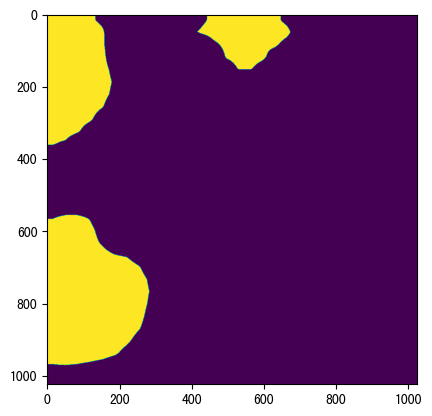

In [13]:
plt.imshow(pred_mask)
plt.show()

06/15 16:14:07 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


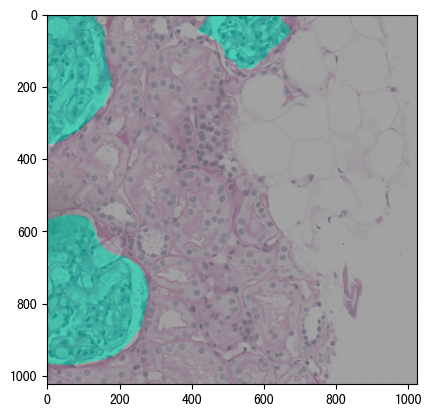

In [14]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

## 语义分割预测结果-连通域分析

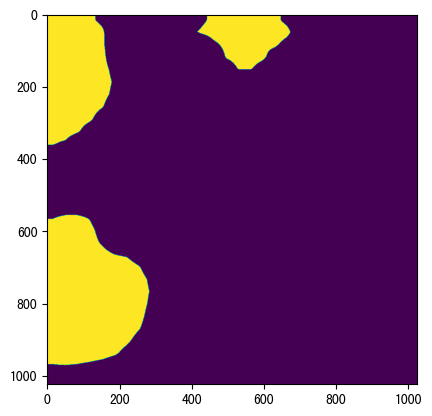

In [15]:
plt.imshow(np.uint8(pred_mask))
plt.show()

In [16]:
connected = cv2.connectedComponentsWithStats(np.uint8(pred_mask), connectivity=4)

In [17]:
# 连通域个数（第一个有可能是全图，可以忽略）
connected[0]

4

In [18]:
# 用整数表示每个连通域区域
connected[1].shape

(1024, 1024)

In [19]:
np.unique(connected[1])

array([0, 1, 2, 3], dtype=int32)

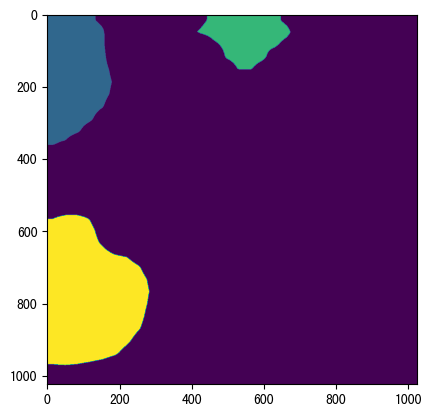

In [20]:
plt.imshow(connected[1])
plt.show()

In [21]:
# 每个连通域外接矩形的左上角X、左上角Y、宽度、高度、面积
connected[2]

array([[     0,      0,   1024,   1024, 881722],
       [     0,      0,    179,    362,  52068],
       [   416,      0,    257,    153,  25212],
       [     0,    556,    283,    416,  89574]], dtype=int32)

In [22]:
# 每个连通域的质心坐标
connected[3]

array([[576.22160613, 517.87757593],
       [ 76.03272643, 165.04407698],
       [549.6245042 ,  60.48782326],
       [116.81237859, 777.05626633]])

## 获取测试集标注

In [23]:
label = mmcv.imread('Glomeruli-dataset/masks/VUHSK_1702_39.png')

In [24]:
label_mask = label[:,:,0]

In [25]:
label_mask.shape

(1024, 1024)

In [26]:
np.unique(label_mask)

array([0, 1], dtype=uint8)

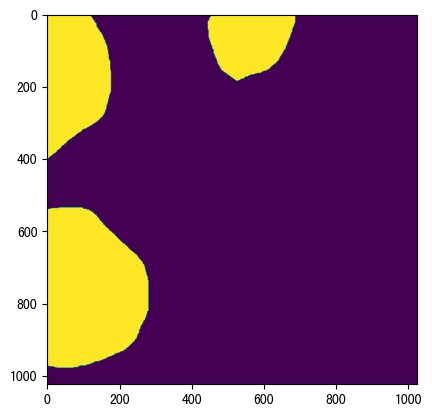

In [27]:
plt.imshow(label_mask)
plt.show()

## 对比测试集标注和语义分割预测结果

In [28]:
# 测试集标注
label_mask.shape

(1024, 1024)

In [29]:
# 语义分割预测结果
pred_mask.shape

(1024, 1024)

In [30]:
# 真实为前景，预测为前景
TP = (label_mask == 1) & (pred_mask==1)

In [31]:
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)

In [32]:
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)

In [33]:
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)

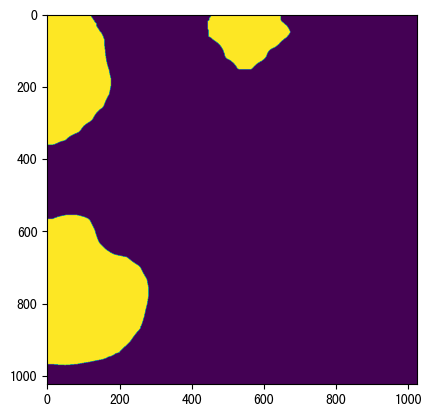

In [34]:
plt.imshow(TP)
plt.show()

In [35]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 10

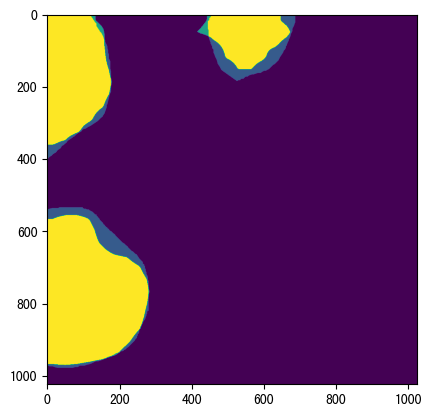

In [36]:
plt.imshow(confusion_map)
plt.show()

## 混淆矩阵

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())

In [39]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [40]:
classes = ('background', 'glomeruili')

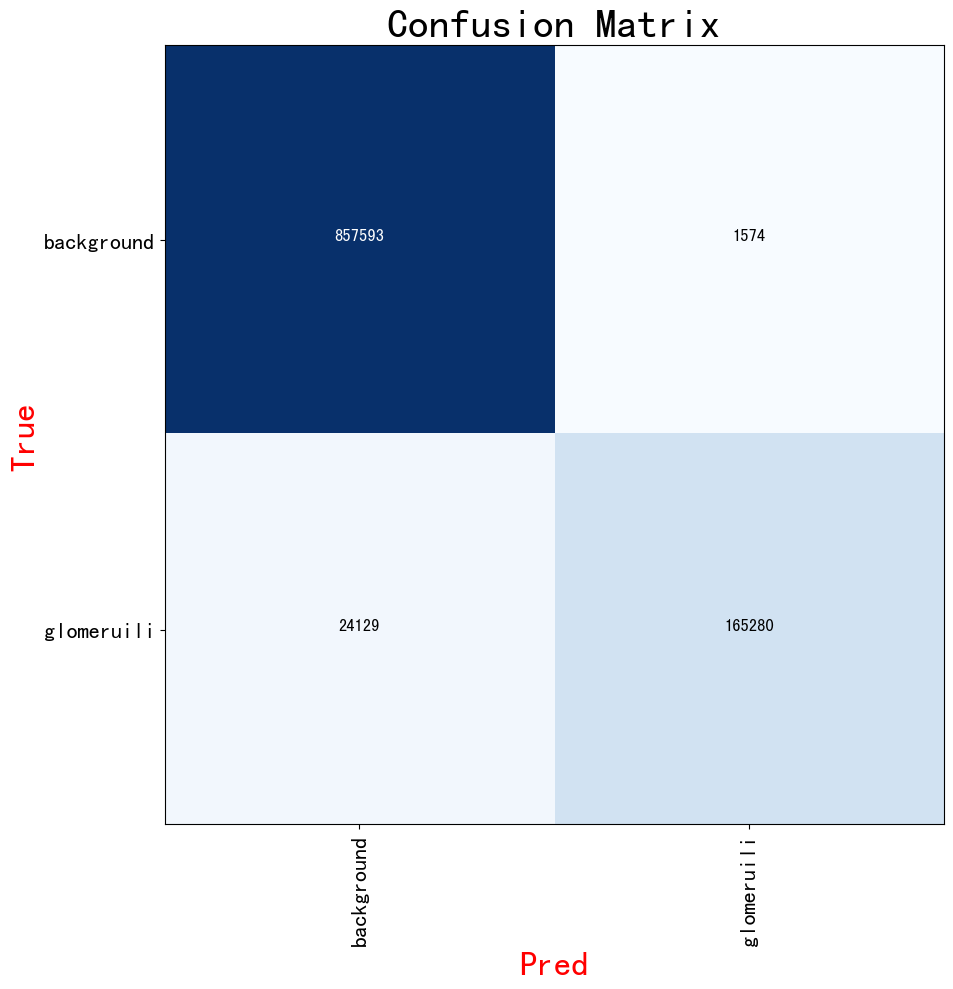

In [41]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

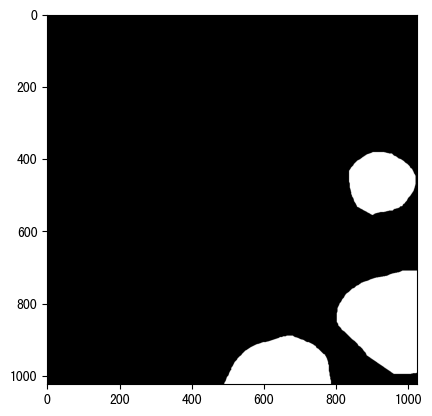

In [46]:
label = mmcv.imread('Glomeruli-dataset/masks/VUHSK_1702_50.png')
plt.imshow(np.uint8(label)*255)
# plt.imshow(label)
plt.show()

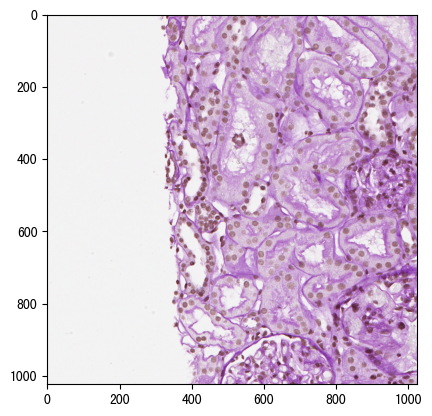

In [44]:
img = mmcv.imread('Glomeruli-dataset/images/VUHSK_1702_50.png')

plt.imshow(img)
plt.show()

## 语义分割预测

In [47]:
result = inference_model(model, img)

In [48]:
result.keys()

['seg_logits', 'pred_sem_seg']

In [49]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [50]:
pred_mask.shape

(1024, 1024)

In [51]:
np.unique(pred_mask)

array([0, 1])

## 可视化语义分割预测结果

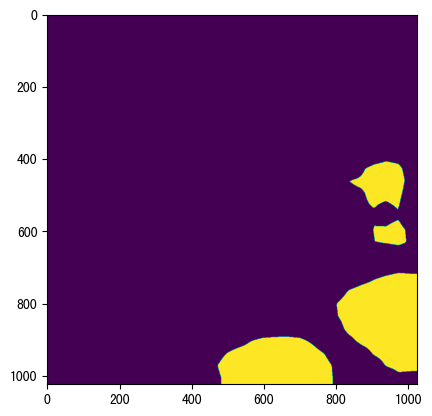

In [52]:
plt.imshow(np.uint8(pred_mask))
plt.show()

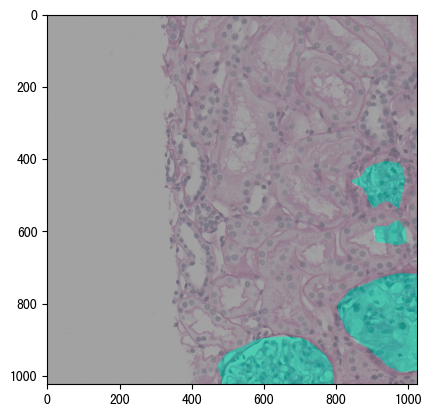

In [53]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

## 语义分割预测结果-连通域分析

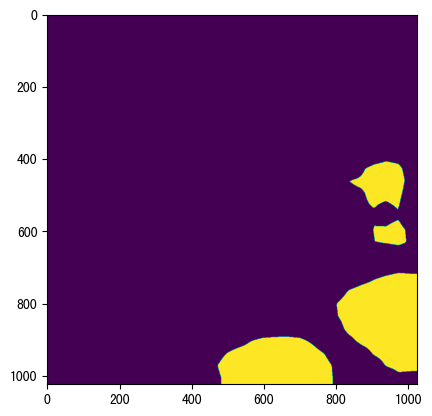

In [54]:
plt.imshow(np.uint8(pred_mask))
plt.show()

In [55]:
connected = cv2.connectedComponentsWithStats(np.uint8(pred_mask), connectivity=4)

In [56]:
# 连通域个数（第一个有可能是全图，可以忽略）
connected[0]

5

In [57]:
# 用整数表示每个连通域区域
connected[1].shape

(1024, 1024)

In [58]:
np.unique(connected[1])

array([0, 1, 2, 3, 4], dtype=int32)

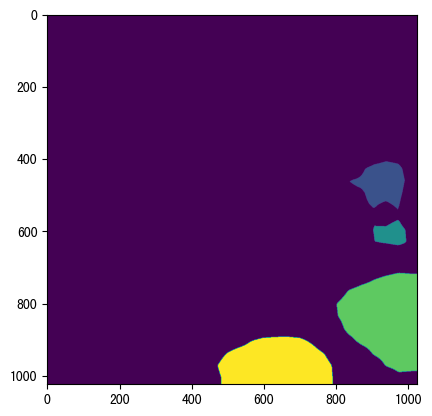

In [59]:
plt.imshow(connected[1])
plt.show()

In [60]:
# 每个连通域外接矩形的左上角X、左上角Y、宽度、高度、面积
connected[2]

array([[     0,      0,   1024,   1024, 952580],
       [   838,    408,    152,    133,  12609],
       [   903,    570,     91,     70,   4560],
       [   802,    716,    222,    275,  44454],
       [   473,    893,    318,    131,  34373]], dtype=int32)

In [61]:
# 每个连通域的质心坐标
connected[3]

array([[479.76714712, 479.67914506],
       [927.26568324, 469.10579745],
       [950.35416667, 608.13618421],
       [933.96936159, 843.85312908],
       [633.80714514, 966.25726588]])

## 获取测试集标注

In [62]:
# label = mmcv.imread('Glomeruli-dataset/masks/VUHSK_1702_39.png')
# label = mmcv.imread('Glomeruli-dataset/masks/SAS_21883_001_48.png')

In [63]:
label_mask = label[:,:,0]

In [64]:
label_mask.shape

(1024, 1024)

In [65]:
np.unique(label_mask)

array([0, 1], dtype=uint8)

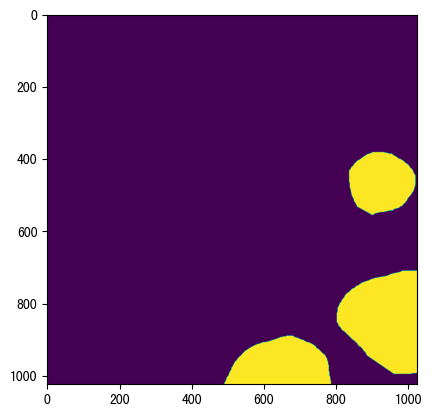

In [66]:
plt.imshow(label_mask)
plt.show()

## 对比测试集标注和语义分割预测结果

In [67]:
# 测试集标注
label_mask.shape

(1024, 1024)

In [68]:
# 语义分割预测结果
pred_mask.shape

(1024, 1024)

In [69]:
# 真实为前景，预测为前景
TP = (label_mask == 1) & (pred_mask==1)

In [70]:
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)

In [71]:
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)

In [72]:
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)

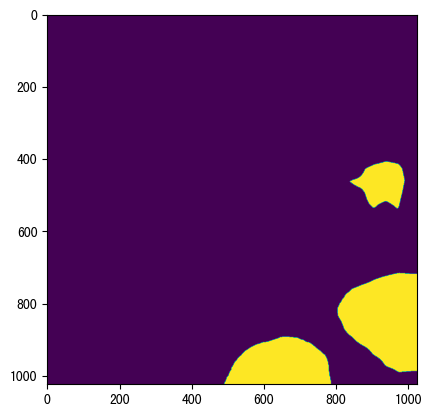

In [73]:
plt.imshow(TP)
plt.show()

In [74]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 10

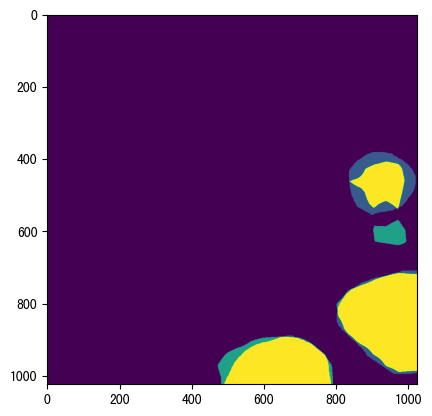

In [75]:
plt.imshow(confusion_map)
plt.show()

## 混淆矩阵

In [76]:
from sklearn.metrics import confusion_matrix

In [77]:
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())

In [78]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [79]:
classes = ('background', 'glomeruili')

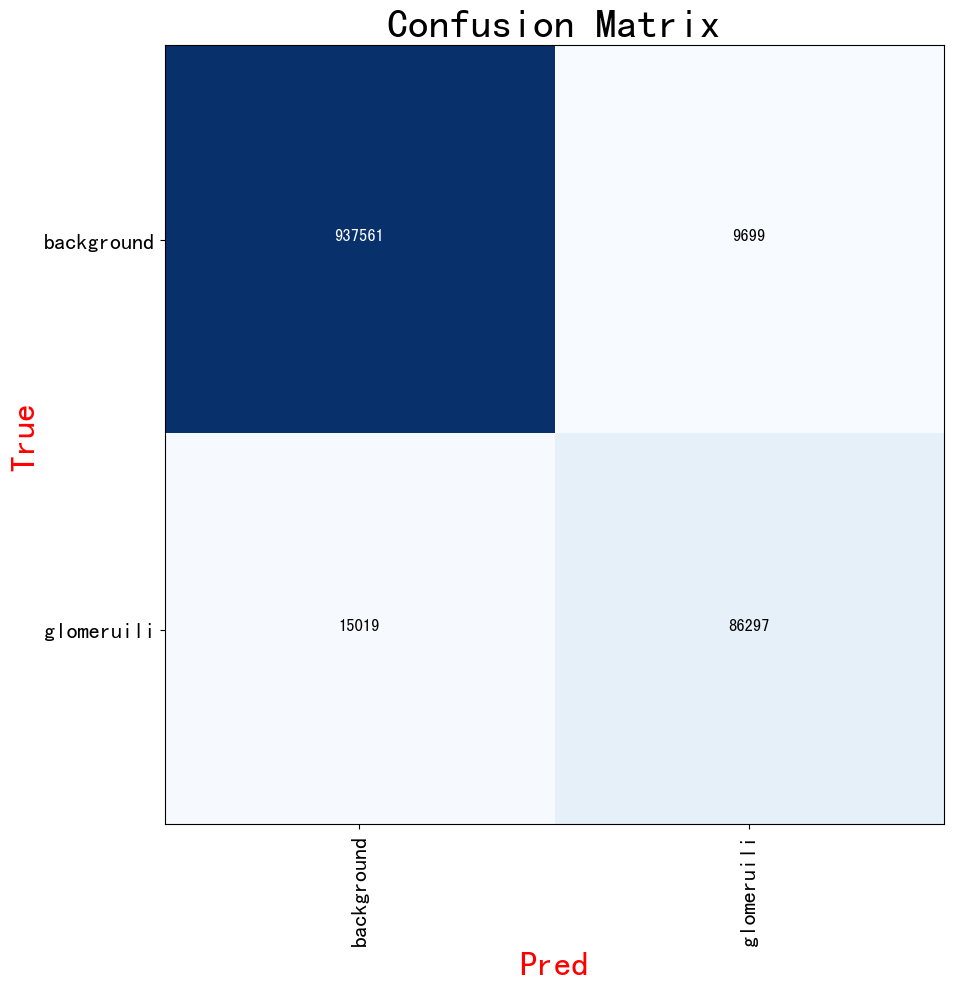

In [80]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')